# 1 Constructing the matrix X

In [1]:
import scipy.sparse
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import lsqr

In [11]:
def construct_X(M,alphas,Np=None):
    if Np==None:
        Np=int(np.sqrt(2)*M)
        if Np%2==0:
            Np+=1
    
    #2xD
    C = np.mgrid[0: M, 0: M] - (M - 1) / 2
    #print(C.shape)
    C = C.reshape(2, -1)
    #print(C.shape)
    C[[0, 1], :] = C[[1, 0], :]
    
    i_indices=[]
    j_indices=[]
    weights=[]
    
    s0=(Np-1)/2
    
    for i,alpha in enumerate(alphas):
        alph_rad = np.radians(alpha)
        rot_mat=np.array([[np.cos(alph_rad), -np.sin(alph_rad)],
                            [np.sin(alph_rad), np.cos(alph_rad)]])
    
        P = rot_mat.dot(C)[0] + s0
        
        for j,p in enumerate(P):
            bin0=int(np.floor(p))
            bin1=int(np.ceil(p))

            if bin0 == bin1:
                    i_indices.append(i * Np + bin0)
                    j_indices.append(j)
                    weights.append(1)
            else:
                val0 = bin1 - p
                val1 = p - bin0

                if bin1 == 0:
                    i_indices.append(i * Np)
                    j_indices.append(j)
                    weights.append(val1)

                elif bin0 == Np - 1:
                    i_indices.append(i * Np + bin0)
                    j_indices.append(p)
                    weights.append(val0)
                else:
                    i_indices.extend([i * Np + bin0, i* Np + bin1])
                    j_indices.extend([j, j])
                    weights.extend([val0, val1])
    
    
    
    X=scipy.sparse.coo_matrix((weights,(i_indices,j_indices)),shape=(len(alphas)*Np,M*M),dtype=np.float32)
    return X

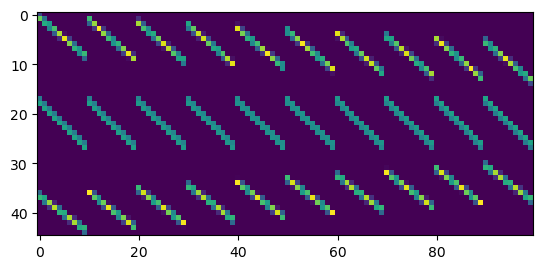

In [12]:
X=construct_X(10,[-33,1,42]).todense()
plt.imshow(X)

# 2 Recovering the image

In [16]:
### The small one
y_small = np.load("C:\\Users\\jw162\\Desktop\\hs_tomography\\y_77.npy")
alphas_small = np.load("C:\\Users\\jw162\\Desktop\\hs_tomography\\alphas_77.npy")
X = construct_X(77, alphas_small, 109).tocsc()

In [21]:
#sparsity
total = X.shape[0] * X.shape[1]
zero= total -len( X.indptr)
sparsity = zero/ total
print(sparsity)

0.9999796845850992


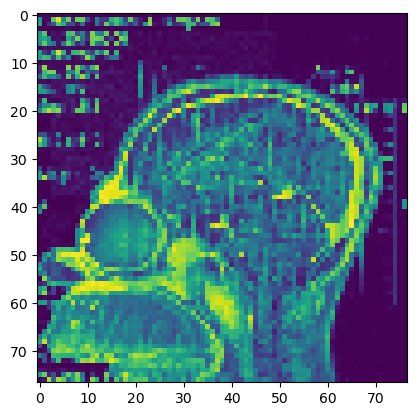

In [17]:
beta = lsqr(X, y_small, atol=1e-08, btol=1e-08)
img = beta[0].reshape(77,77)
plt.imshow(img)

In [18]:
### The big one
y_big = np.load("C:\\Users\\jw162\\Desktop\\hs_tomography\\y_195.npy")
alphas_big = np.load("C:\\Users\\jw162\\Desktop\\hs_tomography\\alphas_195.npy")
X = construct_X(195, alphas_big).tocsc()

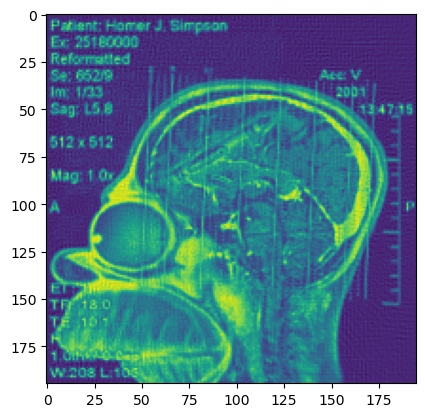

In [19]:
beta = lsqr(X, y_big, atol=1e-05, btol=1e-05)
img = beta[0].reshape(195,195)
plt.imshow(img)

# It seems that H.S. has a pencil in his head so he got a headache. Suppose we can take the pencil out via operation then H.S. will recover!

# 3 Minimizing the radiation dose

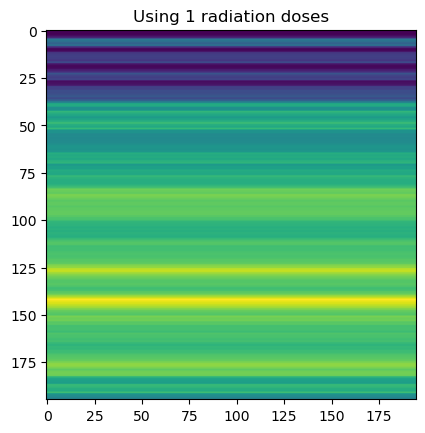

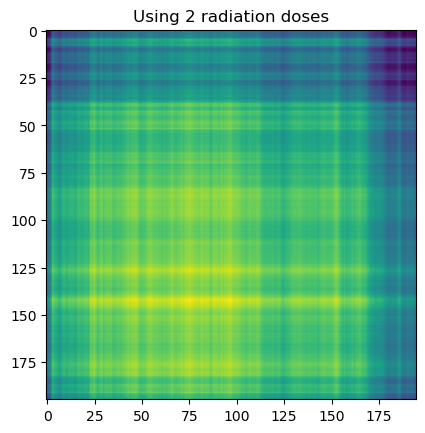

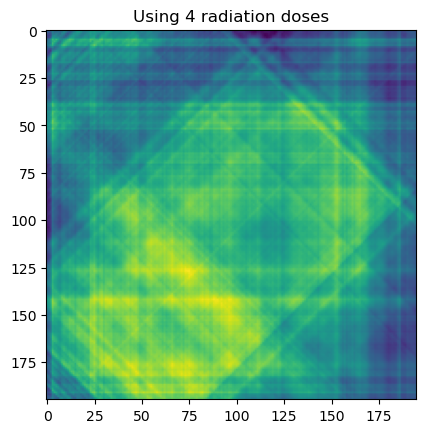

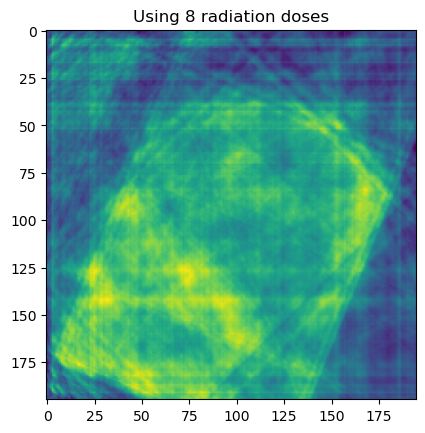

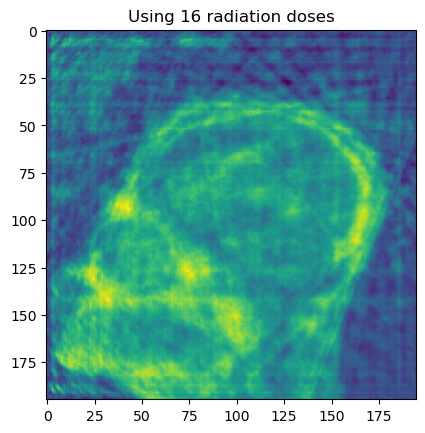

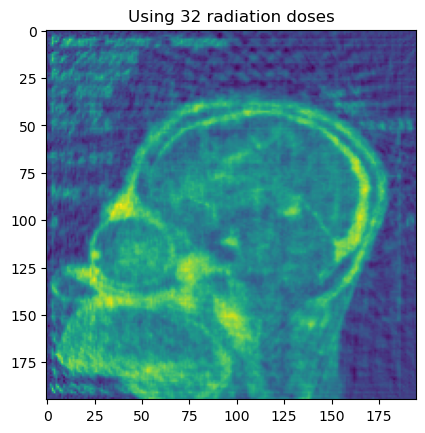

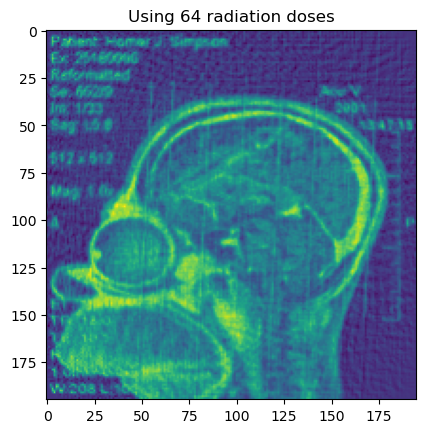

In [27]:
K = 275
alphas_large = np.load("C:\\Users\\jw162\\Desktop\\hs_tomography\\alphas_195.npy")
y_large = np.load("C:\\Users\\jw162\\Desktop\\hs_tomography\\y_195.npy")
nr_doses = [1,2,4,8,16,32,64]
for pltnr, dose in enumerate(nr_doses):
    index = [int(np.ceil(i*len(alphas_large)/float(dose))) for i in range(dose)]
    alphas_sub = alphas_large[index]
    y_sub = np.zeros((dose*K))
    for i,j in enumerate(index):
        y_sub[i*K:(i+1)*K] = y_large[j*K:(j+1)*K]
    A = construct_X(195, alphas_sub, K).tocsc()
    x = lsqr(A, y_sub)
    plt.figure()
    plt.imshow(x[0].reshape(195,195))
    plt.title("Using %d radiation doses" % dose)
    plt.savefig("large_%d.png" %dose)